<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/MC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [37]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))
    acorr = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    decorr_time = np.where(acorr<0)[0][0]
    return len(array) // decorr_time

class Particle():
  def __init__(self,position):
    self.position = np.array(position)

class System():
  def __init__(self,N,L,sigma):
    self.N = N
    self.L = L
    self.sigma = sigma

    self.particles = []
    for i in range(self.N):
      position = np.random.uniform(-self.L/2,self.L/2,3)
      self.particles.append(Particle(position))

    # Check and resolve overlaps
    for i in range(self.N):
        overlap = True
        while overlap:
            overlap = False
            for j in range(i):  # Only check previous particles
                distance = self.minimum_image_distance(self.particles[i].position, self.particles[j].position)
                if distance < self.sigma:  # Overlap detected
                    self.particles[i].position = np.random.uniform(0, self.L, 3)
                    overlap = True
                    break  # Restart check for this particle

    self.energy = self.calculate_energy()

  def minimum_image_distance(self,pos1,pos2):
    diff_vector = pos1 - pos2
    diff_vector = (diff_vector+(self.L/2))%self.L-(self.L/2)
    return np.linalg.norm(diff_vector)

  def calculate_energy(self):
    energy = 0
    for i in range(len(self.particles)):
      for j in range(len(self.particles)):
        if i < j:
          distance = self.minimum_image_distance(self.particles[i].position,self.particles[j].position)
          epsilon = 1.0
          energy += 4*epsilon*((self.sigma/distance)**12 - (self.sigma/distance)**6)
    self.energy = energy
    return energy

  def plot_positions(self):
    positions = [self.particles[i].position for i in range(self.N)]
    positions = np.array(positions)
    x,y,z = positions.T

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x,y,z)
    lim = self.L/2
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_zlim(-lim,lim)
    return ax

class Dynamics():
  def __init__(self,N,L,sigma,nsteps,temperature):
    self.system = System(N,L,sigma)
    self.nsteps = nsteps
    self.T = temperature
    self.energies = []
    self.per_particle_energies = []

  def run_dynamics(self):
    self.accepted = 0
    self.rejected = 0
    for i in range(self.nsteps):
      new_system = copy.deepcopy(self.system)
      rand_particle_index = np.random.randint(0,new_system.N)
      random_movement = np.random.uniform(-new_system.sigma,new_system.sigma)
      random_direction = np.random.randint(3) # 0=x, 1=y, 2=z
      new_system.particles[rand_particle_index].position[random_direction] = new_system.particles[rand_particle_index].position[random_direction] + random_movement
      if np.abs(new_system.particles[rand_particle_index].position[random_direction]) >= new_system.L/2:
        new_system.particles[rand_particle_index].position[random_direction] = (new_system.particles[rand_particle_index].position[random_direction]+(new_system.L/2))%new_system.L-(new_system.L/2)


      new_energy = new_system.calculate_energy()
      delta_E = new_energy - self.system.energy
      if delta_E < 0:
        self.system = new_system
        self.energies.append(new_energy)
        self.accepted += 1
      elif delta_E >= 0:
        boltzmann_factor = np.exp(-delta_E/self.T)
        rand = np.random.random()
        if rand <= boltzmann_factor:
          self.system = new_system
          self.energies.append(new_energy)
          self.accepted += 1
        elif rand > boltzmann_factor:
          self.energies.append(self.system.energy)
          self.rejected += 1
    self.per_particle_energies = np.array(self.energies)/self.system.N

  def plot_energy(self):
    plt.plot(self.per_particle_energies)
    plt.xlabel('Simulation Step')
    plt.ylabel('Per-Particle Energy ($\epsilon$)')



# N/V = 0.5, T = 0.5

In [35]:
# Benchmarking
import time

particle_density = 0.5
nsteps = 100
temperature = 0.5
N = np.arange(10,110,10)
L = (N/particle_density)**(1/3)

for i in range(len(N)):
  d = Dynamics(N[i],L[i],1,nsteps,temperature)
  t1 = time.time()
  d.run_dynamics()
  t2 = time.time()

  print(f'For N = {N[i]}, L = {L[i]}, efficiency = {nsteps/(t2-t1)} steps per second')
  print(f'For N = {N[i]}, L = {L[i]}, <energy>/N = {np.mean(d.per_particle_energies)}\n')

# It seems like N = 70 is where the average starts to converge, but a) that this may
# be because these benchmark simulations are so short and b) that sacrifices a lot of
# computational efficiency. N = 30 gives a reasonable result and is nearly 4 times faster.
# I will use N = 32 from here on because it allows me to set L to exactly 4.

For N = 10, L = 2.7144176165949063, efficiency = 1489.7296375751205 steps per second
For N = 10, L = 2.7144176165949063, <energy>/N = -2.2245721713863347

For N = 20, L = 3.4199518933533937, efficiency = 398.6609612412532 steps per second
For N = 20, L = 3.4199518933533937, <energy>/N = -2.900224511529422

For N = 30, L = 3.9148676411688634, efficiency = 118.40248960312917 steps per second
For N = 30, L = 3.9148676411688634, <energy>/N = -3.117849503287471

For N = 40, L = 4.308869380063767, efficiency = 71.03844961098513 steps per second
For N = 40, L = 4.308869380063767, <energy>/N = -3.0232254349589134

For N = 50, L = 4.641588833612778, efficiency = 69.13337686958936 steps per second
For N = 50, L = 4.641588833612778, <energy>/N = -3.1644551142711492

For N = 60, L = 4.93242414866094, efficiency = 47.554839147834606 steps per second
For N = 60, L = 4.93242414866094, <energy>/N = -3.125541336911249

For N = 70, L = 5.1924941018511035, efficiency = 33.593785103621784 steps per second

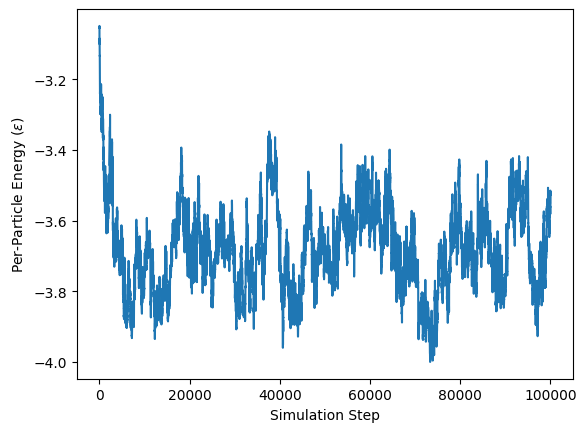

In [48]:
d = Dynamics(32,4,1,100000,0.5)
d.run_dynamics()
d.plot_energy()

In [52]:
for i in range(0,100000,10000):
  print(f'Start = {i}, nsamples = {autocorr1D(d.per_particle_energies[i:])}')

# I want to remove the equilibration, so I will start at step 10000.
# Step 10000 gives the greatest number of independent samples, not
# including steps during the equilibration.

Start = 0, nsamples = 31
Start = 10000, nsamples = 26
Start = 20000, nsamples = 22
Start = 30000, nsamples = 17
Start = 40000, nsamples = 7
Start = 50000, nsamples = 6
Start = 60000, nsamples = 12
Start = 70000, nsamples = 9
Start = 80000, nsamples = 9
Start = 90000, nsamples = 4


In [66]:
start = 10000
nsamples = 26
nsteps = d.nsteps - start
decorr_spacing = (nsteps // nsamples) + 1 # + 1 to round up
independent_samples = []
for i in range(nsamples):
  value = d.per_particle_energies[start+i*decorr_spacing]
  independent_samples.append(value)

print(f'<energy>/N = {np.mean(independent_samples)} +/- {np.std(independent_samples)}')

<energy>/N = -3.7084670203492704 +/- 0.12554017766541453


# N/V = 0.5 T = 2.0

In [68]:
# Benchmarking
import time

particle_density = 0.5
nsteps = 100
temperature = 2.0
N = np.arange(10,110,10)
L = (N/particle_density)**(1/3)

for i in range(len(N)):
  d = Dynamics(N[i],L[i],1,nsteps,temperature)
  t1 = time.time()
  d.run_dynamics()
  t2 = time.time()

  print(f'For N = {N[i]}, L = {L[i]}, efficiency = {nsteps/(t2-t1)} steps per second')
  print(f'For N = {N[i]}, L = {L[i]}, <energy>/N = {np.mean(d.per_particle_energies)}\n')

# In this case, I feel N = 30 gives too different of a result. I will try with N = 40
# to balance accuracy and computational efficiency.

For N = 10, L = 2.7144176165949063, efficiency = 1396.4302717747762 steps per second
For N = 10, L = 2.7144176165949063, <energy>/N = -1.795143024087152

For N = 20, L = 3.4199518933533937, efficiency = 388.85727450647727 steps per second
For N = 20, L = 3.4199518933533937, <energy>/N = -2.7563508003032946

For N = 30, L = 3.9148676411688634, efficiency = 216.6937126696704 steps per second
For N = 30, L = 3.9148676411688634, <energy>/N = -2.7195484943983645

For N = 40, L = 4.308869380063767, efficiency = 117.53010755158873 steps per second
For N = 40, L = 4.308869380063767, <energy>/N = -3.046452496535049

For N = 50, L = 4.641588833612778, efficiency = 71.8434139489106 steps per second
For N = 50, L = 4.641588833612778, <energy>/N = -3.2105296953182836

For N = 60, L = 4.93242414866094, efficiency = 42.46715261065972 steps per second
For N = 60, L = 4.93242414866094, <energy>/N = -3.09996834353384

For N = 70, L = 5.1924941018511035, efficiency = 26.042957582549228 steps per second
F

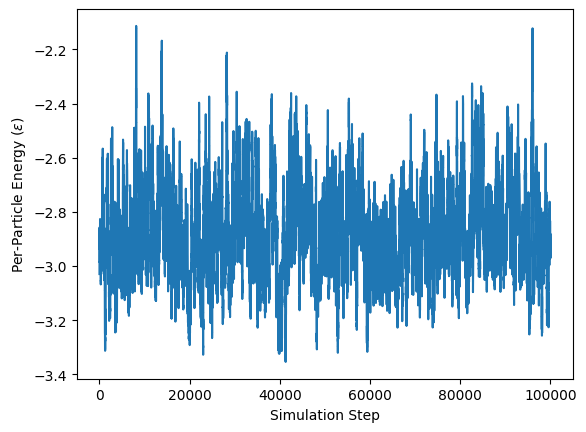

In [74]:
particle_density = 0.5
N = 40
L = (N/particle_density)**(1/3)

d2 = Dynamics(N,L,1,100000,2.0)
d2.run_dynamics()
d2.plot_energy()

In [75]:
for i in range(0,100000,10000):
  print(f'Start = {i}, nsamples = {autocorr1D(d2.per_particle_energies[i:])}')

# I don't see much cause to remove the "equilibration" here, so
# I will simply start from 0.

Start = 0, nsamples = 95
Start = 10000, nsamples = 88
Start = 20000, nsamples = 80
Start = 30000, nsamples = 70
Start = 40000, nsamples = 58
Start = 50000, nsamples = 60
Start = 60000, nsamples = 39
Start = 70000, nsamples = 67
Start = 80000, nsamples = 46
Start = 90000, nsamples = 30


In [77]:
start = 0
nsamples = 95
nsteps = d2.nsteps - start
decorr_spacing = (nsteps // nsamples) + 1 # + 1 to round up
independent_samples = []
for i in range(nsamples):
  value = d2.per_particle_energies[start+i*decorr_spacing]
  independent_samples.append(value)

print(f'<energy>/N = {np.mean(independent_samples)} +/- {np.std(independent_samples)}')

<energy>/N = -2.8776304665458645 +/- 0.1590138098343878
